In [100]:
# necessary imports 

import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch import nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from nltk.corpus import stopwords
import re
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [101]:
# import stop words 
stop_words = set(stopwords.words('english'))

In [102]:
file_path = "scraped_data/BABE_scraped.csv" # path to babe dataset
data = pd.read_csv(file_path)

In [103]:
def preprocess(text): 
    text = text.lower() # to lower case 
    text = re.sub(r'http\S+', '', text) # remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text) # remove non-alphabetical characters
    text = ' '.join([word for word in text.split() if word not in stop_words]) # remove stopwords 
    
    return text

data['content'] = data['content'].fillna('') # remove missing values 
data['content'] = data['content'].apply(preprocess) # apply preprocess function


# train, val, test split
train_data, remaining_data = train_test_split(data, test_size=0.3, random_state=42)
validation_data, test_data = train_test_split(remaining_data, test_size=0.5, random_state=42)

In [104]:
# load the GloVe embeddings

# *** Change the 'glove_file' to your proper file path! ***
glove_file = "../Homeworks/HW2_Language_Models_Neural_Networks/glove/glove.6B.50d.txt"

embeddings_dict = {}
with open(glove_file, 'r', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_dict[word] = vector

print(f'Loaded {len(embeddings_dict)} words from GloVe.')

vocab_size = len(embeddings_dict) + 1
embedding_dim = 50
embedding_matrix = np.zeros((vocab_size, embedding_dim))

word2id = {'<pad>': 0}
for i, (word, vector) in enumerate(embeddings_dict.items(), 1):
    embedding_matrix[i] = vector
    word2id[word] = i
    

Loaded 400000 words from GloVe.


In [105]:
from torch.utils.data import DataLoader, Dataset
import torch

def encode_text(text, word2id):
    return [word2id.get(word, word2id['<pad>']) for word in text.split()]

class NewsDataset(Dataset):
    def __init__(self, data, word2id):
        self.data = data
        self.word2id = word2id

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['content']
        label = self.data.iloc[idx]['type_class']
        encoded_text = encode_text(text, self.word2id)
        return torch.tensor(encoded_text, dtype=torch.long), torch.tensor(label, dtype=torch.long)

def collate_batch(batch):
    label_list, text_list = [], []
    for _text, _label in batch:
        label_list.append(_label)
        text_list.append(_text)
    text_list = pad_sequence(text_list, batch_first=True, padding_value=0)
    labels = torch.tensor(label_list, dtype=torch.long)
    return text_list, labels

# creating our datasets and data loaders
train_dataset = NewsDataset(train_data, word2id)
val_dataset = NewsDataset(validation_data, word2id)
test_dataset = NewsDataset(test_data, word2id)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_batch)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=collate_batch)

In [106]:
class SimpleRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, pretrained_embeddings):
        super(SimpleRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight.data.copy_(torch.from_numpy(pretrained_embeddings))
        self.embedding.weight.requires_grad = False  # We do not train the embedding layer
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x) # embedding layer using GloVe
        h0 = torch.zeros(1, x.size(0), self.rnn.hidden_size).to(x.device) # initial hidden state
        out, _ = self.rnn(x, h0) # forward prop
        out = self.fc(out[:, -1, :]) # pass output of last timestep 
        
        return out


In [107]:
model = SimpleRNN(vocab_size, embedding_dim, hidden_dim=50, output_dim=3, pretrained_embeddings=embedding_matrix)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.01)

# training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for texts, labels in train_loader:
        outputs = model(texts)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # validation loop
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for texts, labels in val_loader:
            outputs = model(texts)
            val_loss += criterion(outputs, labels).item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}, Validation Loss: {val_loss / len(val_loader):.4f}')


Epoch [1/10], Training Loss: 1.0440, Validation Loss: 0.9734
Epoch [2/10], Training Loss: 0.6580, Validation Loss: 0.9472
Epoch [3/10], Training Loss: 0.8133, Validation Loss: 0.9880
Epoch [4/10], Training Loss: 0.8786, Validation Loss: 1.0840
Epoch [5/10], Training Loss: 0.5643, Validation Loss: 1.0496
Epoch [6/10], Training Loss: 0.8096, Validation Loss: 1.0043
Epoch [7/10], Training Loss: 1.0281, Validation Loss: 0.9952
Epoch [8/10], Training Loss: 0.8391, Validation Loss: 0.9555
Epoch [9/10], Training Loss: 0.9832, Validation Loss: 1.0021
Epoch [10/10], Training Loss: 0.8202, Validation Loss: 0.9584


In [108]:
model.eval()
total = 0
correct = 0
with torch.no_grad():
    for texts, labels in test_loader:
        outputs = model(texts)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model on the test set: {100 * correct / total}%')

Accuracy of the model on the test set: 51.02040816326531%


In [109]:
def get_all_predictions(model, data_loader):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for texts, labels in data_loader:
            outputs = model(texts)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_predictions, all_labels

predictions, true_labels = get_all_predictions(model, test_loader)

Classification Report:
              precision    recall  f1-score   support

        Left       0.62      0.58      0.60       141
      Center       0.00      0.00      0.00        22
       Right       0.38      0.52      0.44        82

    accuracy                           0.51       245
   macro avg       0.33      0.37      0.35       245
weighted avg       0.48      0.51      0.49       245

Confusion Matrix:


/Users/benlipman/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/benlipman/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/benlipman/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


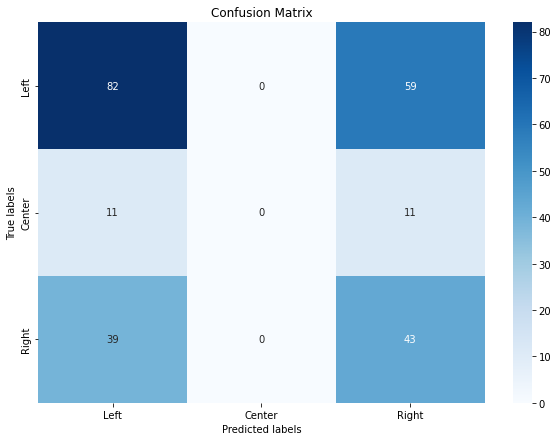

In [110]:
print("Classification Report:")
print(classification_report(true_labels, predictions, target_names=['Left', 'Center', 'Right']))

print("Confusion Matrix:")
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Left', 'Center', 'Right'], yticklabels=['Left', 'Center', 'Right'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()